🟢 Using device: cpu


100%|██████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:35<00:00, 278kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 91.3kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:02<00:00, 819kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.43MB/s]


Epoch [1/5] | D Loss: 1.1429 | G Loss: 0.7670
Epoch [2/5] | D Loss: 0.9418 | G Loss: 1.1970
Epoch [3/5] | D Loss: 1.0747 | G Loss: 1.0505
Epoch [4/5] | D Loss: 0.9466 | G Loss: 1.1022
Epoch [5/5] | D Loss: 0.7933 | G Loss: 1.2441

✅ Training completed in 401.12 seconds.
💾 Generator model saved as 'models/generator_mnist.pth'


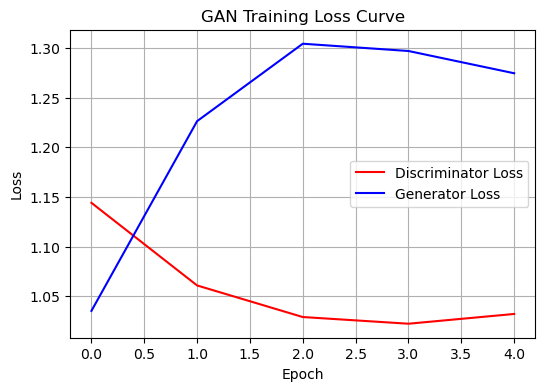

🔁 Generator model reloaded successfully!


C:\Users\datta\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


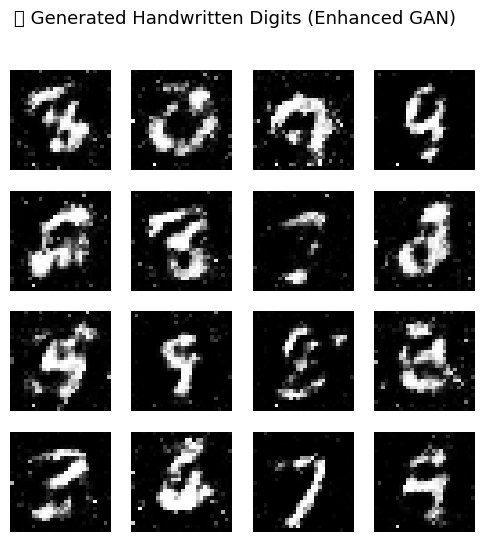

In [8]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🟢 Using device: {device}")

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


G, D = Generator().to(device), Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

epochs = 5
losses_G, losses_D = [], []

start_time = time.time()
G.train(); D.train()

for epoch in range(epochs):
    total_G, total_D = 0, 0
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1).to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        # --- Train Discriminator ---
        outputs_real = D(imgs)
        d_loss_real = criterion(outputs_real, real_labels)

        z = torch.randn(imgs.size(0), 100).to(device)
        fake_imgs = G(z)
        outputs_fake = D(fake_imgs.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        z = torch.randn(imgs.size(0), 100).to(device)
        fake_imgs = G(z)
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        total_D += d_loss.item()
        total_G += g_loss.item()

    losses_D.append(total_D / len(dataloader))
    losses_G.append(total_G / len(dataloader))

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

print(f"\n✅ Training completed in {time.time() - start_time:.2f} seconds.")

os.makedirs("models", exist_ok=True)
torch.save(G.state_dict(), "models/generator_mnist.pth")
print("💾 Generator model saved as 'models/generator_mnist.pth'")

# Step 8: Plot Training Losses
plt.figure(figsize=(6, 4))
plt.plot(losses_D, label="Discriminator Loss", color="red")
plt.plot(losses_G, label="Generator Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

G_loaded = Generator().to(device)
G_loaded.load_state_dict(torch.load("models/generator_mnist.pth"))
G_loaded.eval()
print("🔁 Generator model reloaded successfully!")

z = torch.randn(16, 100).to(device)
generated = G_loaded(z).view(-1, 1, 28, 28).cpu().detach()

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated[i][0], cmap='gray')
    plt.axis('off')

plt.suptitle("🧠 Generated Handwritten Digits (Enhanced GAN)", fontsize=13)
plt.show()
